## Let's run intron clustering to annotate alternative splicing events given observed junctions in our cells 

In [191]:
# Load LeafletSC 
import LeafletSC
import os
import pandas as pd 

# Define path that contains some junction files (only 2 files are used for this example, corresponding to 2 individual cells)
juncs_path = "/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/"
print("The junctions are loaded from the following path: " + juncs_path) 

# print the files in the path 
print("The files in the path are: " + str(os.listdir(juncs_path)))

# define path for saving the output data 
output_path = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/"

The junctions are loaded from the following path: /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/
The files in the path are: ['B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes', 'B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes']


### Let's first define some parameters for the analysis

In [192]:
from LeafletSC.clustering.find_intron_clusters import main as find_intron_clusters
from LeafletSC.clustering.prepare_model_input import main as prep_model_input
from LeafletSC.clustering.find_intron_clusters import visualize_junctions

# junc_files defines a path for where junction files can be found, in this case, the path is defined above
junc_files = juncs_path

# we provide a gtf file for the human genome as well to make better sense of the junctions that are detected in cells
# please replace with the path to the gtf file on your system
gtf_file="/gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf" 

# define additional parameters 
sequencing_type = "single_cell"

# ensure output files are to be saved in output_path 
output_file = output_path + "test_intron_clusters"
junc_bed_file= output_path + "test_juncs.bed" # you can load this file into IGV to visualize the junction coordinates 
min_intron_length = 50
max_intron_length = 500000
threshold_inc = 0.05 
min_junc_reads = 2
min_num_cells_wjunc = 2
keep_singletons = False # ignore junctions that do not share splice sites with any other junction (likely const)
junc_suffix = "*.juncswbarcodes" # depends on how you ran regtools 

### Run intron clustering 

In [193]:
all_juncs_df = find_intron_clusters(junc_files=junc_files, gtf_file=gtf_file, output_file=output_file, 
                       sequencing_type=sequencing_type, junc_bed_file=junc_bed_file, 
                       threshold_inc=threshold_inc, min_intron = min_intron_length,
                       max_intron=max_intron_length, min_junc_reads=min_junc_reads,
                       singleton=keep_singletons,
                       junc_suffix=junc_suffix, min_num_cells_wjunc=min_num_cells_wjunc,
                       run_notebook = True)

Loading files obtained from single_cell sequencing
Reading in junction files from /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions
The number of junction files to be processed is 2


100%|██████████| 2/2 [00:00<00:00, 18.48it/s]

The gtf file you provided is /gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf
Reading the gtf may take a minute...



INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


Reading gtf file took 119.98 seconds
The number of unique exons is 411865
The number of unique transcript ids is 115526
The number of unique gene ids is 62668
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Done extracting exons from gtf file
Cleaning up 'chrom' column
Making gr object from all junctions across all cell types
The number of junctions prior to assessing distance to exons is 12876
Annotating junctions with known exons based on input gtf file
The number of junctions after assessing distance to exons is 11689
Clustering intron splicing events by gene_id
The number of clusters after clustering by gene_id is 11189
The number of junctions after removing singletons is 11688
The number of clusters after removing singletons is 11188
The number of clusters after filtering for shared splice sites is 214
The number of junctions after filtering for shared splice sites is 703
Refining intron clusters to account for junction usage ratio threshold...
Done refining clusters!
The 

In [194]:
# load bed file 
juncs_bed = pd.read_csv(junc_bed_file, sep="\t", header=None)
# remove columns 3 and 4 
juncs_bed = juncs_bed.drop(columns=[3, 4])
juncs_bed.columns = ["Chromosome", "Start", "End", "Strand", "junction_id", "Start_b", "End_b", "gene_id", "gene_name", "transcript_id", "exon_id"]

# cmobine with all_juncs_df and prep df for visualization 
dat_vis = all_juncs_df[["chrom", "chromStart", "chromEnd", "strand", "intron_length", "counts_total", "junction_id", "Cluster"]]
dat_vis = dat_vis.drop_duplicates()
# merge dat_vis with juncs_bed using all common columns 
dat_vis = dat_vis.merge(juncs_bed, how="left", on=["junction_id"])

    chrom  chromStart_kb  chromEnd_kb strand  intron_length  counts_total  \
331     6      41936.107    41937.234      -           1127            69   
332     6      41936.695    41937.234      -            539           288   
330     6      41936.107    41936.558      -            451           297   

       Start_b      End_b            exon_id  
331  41934.955  41936.107  ENSE00001892622.1  
332  41936.558  41936.695  ENSE00003562299.1  
330  41934.955  41936.107  ENSE00001892622.1  
The junction of interest is 6_41936107_41937234


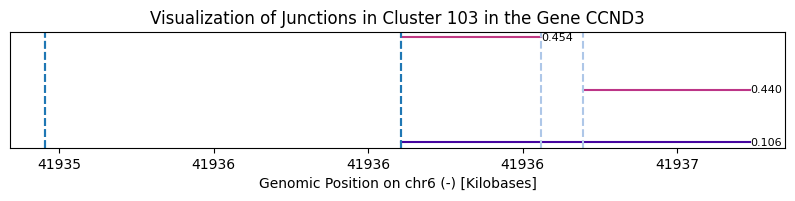

In [208]:
#from LeafletSC.clustering.find_intron_clusters import visualize_junctions
junc_id = all_juncs_df.junction_id.sample(1).values[0]
j = junc_id
visualize_junctions(dat_vis, j, p_usage_ratio=True)

### Now let's convert the intron clusters to a format that can be used by LeafletSC

In [ ]:
intron_clusters = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/test_intron_clusters_50_500000_2_20240309_single_cell.gz" # path to the intron clusters file
output_file = output_path + "test_model_input" # name of the output file
has_genes = "yes" # since we used a gtf file to obtain the intron clusters, we can set this to yes
chunk_size = 5000 # number of junctions to process at a time from the intron clusters files
metadata = None # can replace with path, if metadata is available for cells (cell type, origin, library ID...)

In [ ]:
prep_model_input(intron_clusters, output_file, has_genes, chunk_size, metadata)

### Take a quick look at the input file that will go into the model to get familiarized with all the columns

In [ ]:
model_input_data = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/test_model_input.h5"
summarized_data = pd.read_hdf(model_input_data, 'df')
print(summarized_data.head())

#### Note that fow now, the values in cell_type default to the cell's path, in the future it will be possible to specify the cell type in the metadata file

In [ ]:
summarized_data.cell_type.unique()

In [ ]:
# let's see all the columns in the summarized data
print(summarized_data.columns)

#### We can quickly visualize the overall junction usage ratio distribution across all cells

In [ ]:
print(summarized_data.junc_ratio.hist())

### Now we have everything need to run the Leaflet mixture model! Please refer to the next notebook for the next steps.